In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
import timeit
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score,precision_score,recall_score,RocCurveDisplay
from matplotlib import pyplot

In [2]:
x_resampled=pd.read_csv('resampled_without_encoding.csv')
x_resampled_encoding=pd.read_csv('resampled_with_encoding.csv')
y_resampled=pd.read_csv('y_resampled.csv')

## Modelling

### Data with Resampling and without OneHotEncoding

In [3]:
X = x_resampled.values
Y = np.squeeze(y_resampled.values)
X_train,X_test1,y_train,y_test1=train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler().fit(X_train)
train_sc = scaler.transform(X_train)
test_sc = scaler.transform(X_test1)

model=BaggingClassifier(random_state=48)
start_time = timeit.default_timer()
model.fit(train_sc,y_train)
elapsed = timeit.default_timer() - start_time
y_pred1=model.predict(test_sc)
print("Time taken to fit the model in sec is ",elapsed)
print(f"Accuracy score:{accuracy_score(y_test1, y_pred1):.4f}")
print(f"F1 score : {f1_score(y_test1, y_pred1):.4f}")
print(f"Recall score : {recall_score(y_test1, y_pred1):.4f}")
print(f"Precision score : {precision_score(y_test1, y_pred1):.4f}")

Time taken to fit the model in sec is  122.2505424
Accuracy score:0.9751
F1 score : 0.9747
Recall score : 0.9567
Precision score : 0.9933


<AxesSubplot:>

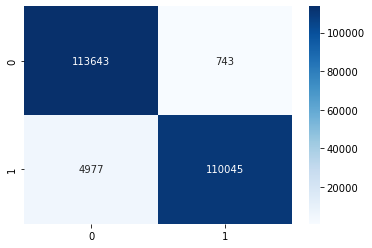

In [4]:
sns.heatmap(confusion_matrix(y_test1,y_pred1),annot=True,fmt='', cmap='Blues')

In [5]:
print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98    114386
           1       0.99      0.96      0.97    115022

    accuracy                           0.98    229408
   macro avg       0.98      0.98      0.98    229408
weighted avg       0.98      0.98      0.98    229408



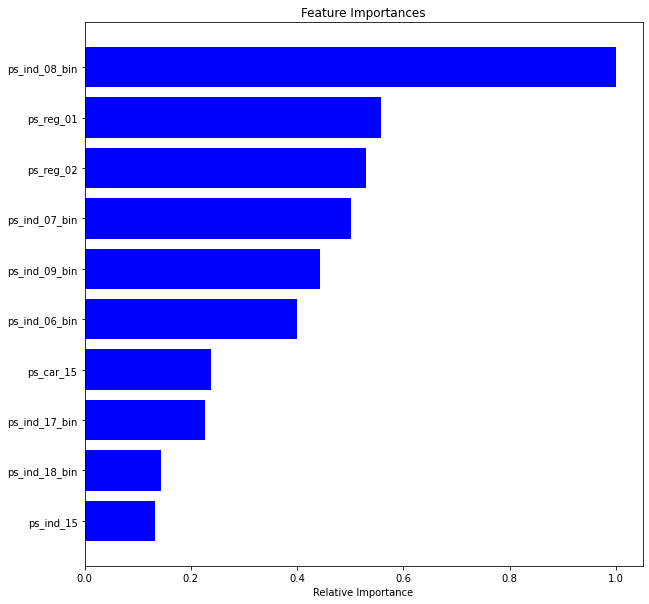

In [7]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in model.estimators_
], axis=0)

feat_imp = pd.DataFrame({"Col": x_resampled.columns})
feat_imp["Coef"] = feature_importances
feat_imp = feat_imp.sort_values("Coef", ascending=False)
#Scale Weights
feat_imp["FeatImp"] = (
        (feat_imp["Coef"] - feat_imp["Coef"].min())
        / (feat_imp["Coef"].max() - feat_imp["Coef"].min())
    ).round(4)

num_features = 10 
pyplot.figure(figsize=(10,10))
pyplot.title('Feature Importances')
# only plot the customized number of features
pyplot.barh(range(num_features), feat_imp['FeatImp'][:num_features][::-1], color='b', align='center')
pyplot.yticks(range(num_features), feat_imp['Col'][:num_features][::-1])
pyplot.xlabel('Relative Importance')
pyplot.show()

### Data with Resampling and with OneHotEncoding

In [8]:
X = x_resampled_encoding.values
Y = np.squeeze(y_resampled.values)
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler().fit(X_train)
train_sc = scaler.transform(X_train)
test_sc = scaler.transform(X_test)

model=BaggingClassifier(random_state=48)
start_time = timeit.default_timer()
model.fit(train_sc,y_train)
elapsed = timeit.default_timer() - start_time
y_pred1=model.predict(test_sc)
print("Time taken to fit the model in sec is ",elapsed)
print(f"Accuracy score:{accuracy_score(y_test, y_pred1):.4f}")
print(f"F1 score : {f1_score(y_test, y_pred1):.4f}")
print(f"Recall score : {recall_score(y_test, y_pred1):.4f}")
print(f"Precision score : {precision_score(y_test, y_pred1):.4f}")

Time taken to fit the model in sec is  348.1103514000001
Accuracy score:0.9733
F1 score : 0.9729
Recall score : 0.9559
Precision score : 0.9904


In [9]:
model.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 48,
 'verbose': 0,
 'warm_start': False}

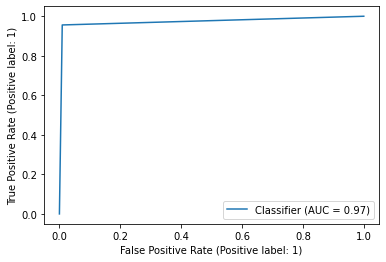

In [10]:
RocCurveDisplay.from_predictions(y_test, y_pred1)

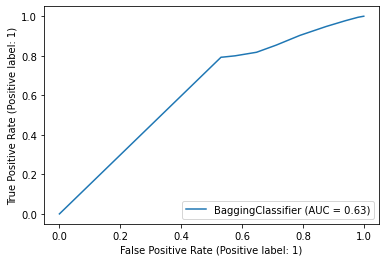

In [11]:
RocCurveDisplay.from_estimator(model,X_test,y_test)

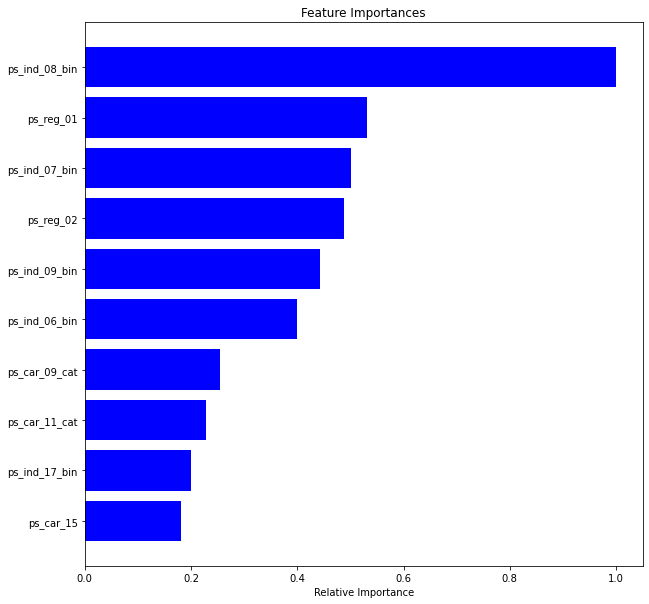

In [12]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in model.estimators_
], axis=0)

feat_imp = pd.DataFrame({"Col": x_resampled_encoding.columns})
feat_imp["Coef"] = feature_importances
feat_imp["Col"] = feat_imp["Col"].apply(lambda x: (x.split('cat')[0]+'cat') if 'cat' in x else x)
feat_imp = feat_imp.groupby("Col",as_index=False).sum().sort_values("Coef", ascending=False)
#Scale Weights
feat_imp["FeatImp"] = (
        (feat_imp["Coef"] - feat_imp["Coef"].min())
        / (feat_imp["Coef"].max() - feat_imp["Coef"].min())
    ).round(4)

num_features = 10 
pyplot.figure(figsize=(10,10))
pyplot.title('Feature Importances')
# only plot the customized number of features
pyplot.barh(range(num_features), feat_imp['FeatImp'][:num_features][::-1], color='b', align='center')
pyplot.yticks(range(num_features), feat_imp['Col'][:num_features][::-1])
pyplot.xlabel('Relative Importance')
pyplot.show()

### Cross Validation

In [13]:
rf_reg = BaggingClassifier(random_state=48)

start_time = timeit.default_timer()
rf_reg.fit(train_sc,y_train)
#perform k fold

cv_r2_scores_rf = cross_val_score(rf_reg, X, Y, cv=5,scoring='r2')
print(cv_r2_scores_rf)
print("Mean 5-Fold R Squared: {}".format(np.mean(cv_r2_scores_rf)))

elapsed = timeit.default_timer() - start_time
print(elapsed)

[0.61378853 0.9646567  0.96359309 0.96479619 0.96451721]
Mean 5-Fold R Squared: 0.8942703459012543
2099.7889486


* We see that the metrics for all folds in cross_val_score are uniform so it can be concluded that the model is able to generalise
* As 4 subsets gave accuracy of 98 we can conside the above model result is not overfitting

#### There is same accuracy with and without OneHotEncoding